## Requirements

- predict net rate of bike rentals for a give station *rate defined as (trips ended - trips started) / hr
    - expect that the primary factors influencing rate will be:
        - time of day
        - weather
        - station location
- EDA
    - Tableau Top Stations by year https://public.tableau.com/views/BikeShare_16361485366690/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link
    
    - Maybe take this guy's advice: https://hrngok.github.io/posts/bay_area%20bike%20data/
- data wrangling

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
stations = pd.read_csv('../data/station_data.csv')
trips = pd.read_csv('../data/trip_data.csv',
                    parse_dates=['Start Date', 'End Date'], 
                    infer_datetime_format=True)
weather = pd.read_csv('../data/weather_data.csv')

In [4]:
trip_df = pd.read_csv("../data/trip_data.csv", 
                    parse_dates=['Start Date', 'End Date'], 
                    infer_datetime_format=True)

### Start by inspecting data

In [3]:
stations.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [4]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          76 non-null     int64  
 1   Name        76 non-null     object 
 2   Lat         76 non-null     float64
 3   Long        76 non-null     float64
 4   Dock Count  76 non-null     int64  
 5   City        76 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 3.7+ KB


In [5]:
trips.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [6]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Trip ID          354152 non-null  int64 
 1   Start Date       354152 non-null  object
 2   Start Station    354152 non-null  int64 
 3   End Date         354152 non-null  object
 4   End Station      354152 non-null  int64 
 5   Subscriber Type  354152 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.2+ MB


In [3]:
'''
A note included with the data indicates that several stations were
relocated. Those include stations 23, 24, 49, 69 and 72, which
became 85, 86, 87, 88 and 89, respectively. Subsequently, 89 later
became 90, as well.
'''
moved_stations=[23, 24, 49, 69, 72]
new_stations1=[85, 86, 87, 88, 89]
new_stations2=[90]

In [4]:
replace_zip= list(zip(moved_stations, new_stations1))

In [11]:
for s1, s2 in replace_zip:
    trips.loc[trips["Start Station"]==s1, "Start Station"]=s2

In [12]:
trips.loc[trips["Start Station"]==89, "Start Station"]=90

In [13]:
for s1, s2 in replace_zip:
    trips.loc[trips["End Station"]==s1, "End Station"]=s2

In [14]:
trips.loc[trips["End Station"]==89, "End Station"]=90

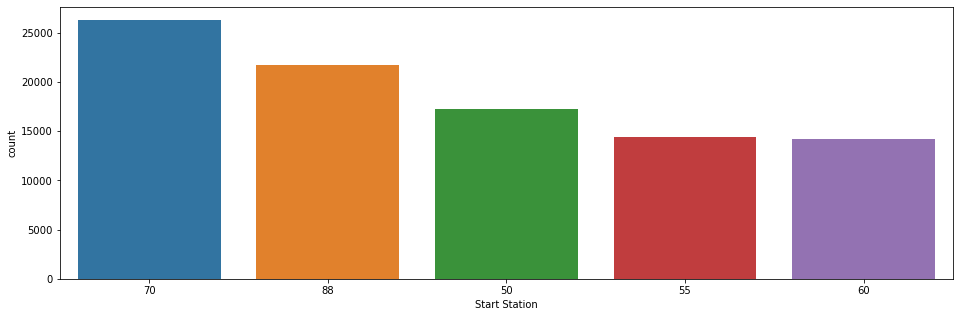

In [65]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=trips["Start Station"], order= trips['Start Station'].value_counts().index[:5], ax=ax);

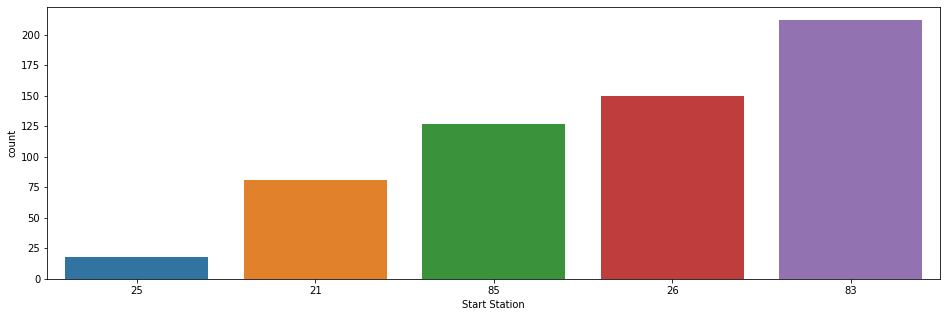

In [41]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=trips["Start Station"], order= trips['Start Station'].value_counts(ascending=True).index[:5], ax=ax);

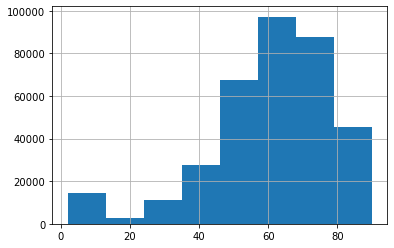

In [42]:
trips['Start Station'].hist(bins=int(np.sqrt(len(stations.Id))));

In [15]:
trips['month'] = trips['Start Date'].dt.month
trips['day'] = trips['Start Date'].dt.dayofweek
trips['hour'] = trips['Start Date'].dt.hour

In [16]:
weekdays=trips[trips["Start Date"].dt.weekday <5]
weekends=trips[trips["Start Date"].dt.weekday >=5]

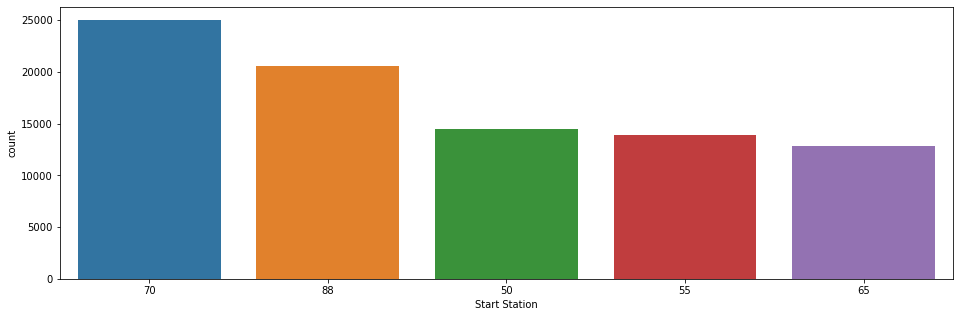

In [68]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=weekdays["Start Station"], order= weekdays['Start Station'].value_counts().index[:5], ax=ax);

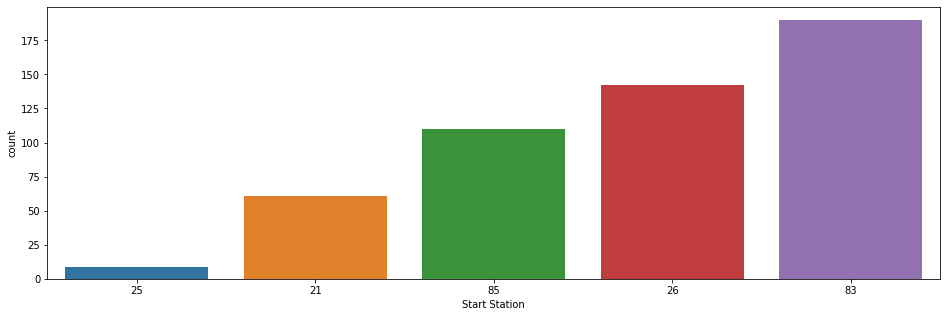

In [69]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=weekdays["Start Station"], order= weekdays['Start Station'].value_counts(ascending =True).index[:5], ax=ax);

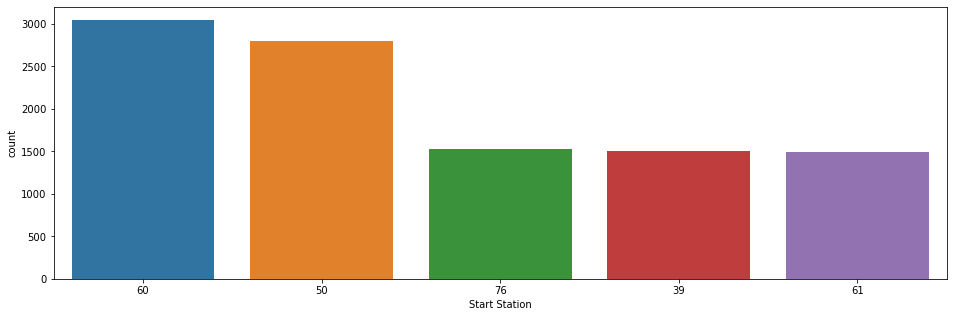

In [70]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=weekends["Start Station"], order= weekends['Start Station'].value_counts().index[:5], ax=ax);

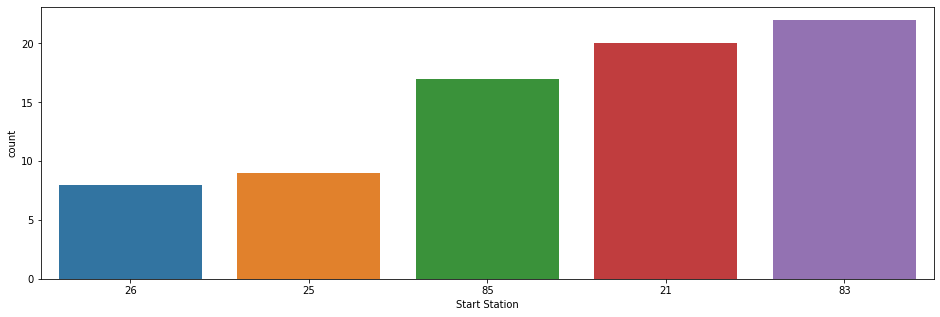

In [71]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=weekends["Start Station"], order= weekends['Start Station'].value_counts(ascending =True).index[:5], ax=ax);

In [17]:
def group_plot(df, lst, agg_func, labelx, labely, title):
    '''
    Takes a dataframe, a list of columns to groupby, an aggregation function for the groups, 
    3 strings: label of x-axis, label of y-axis and title returns a line plot
    Plots the data with labels and title.
    '''
    plt.style.use('fivethirtyeight')
    group= getattr(df.groupby(lst), agg_func)()/1000
    ax= group.plot(figsize=(11,4), rot=70, fontsize=11)        
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_title(title)
    plt.show()

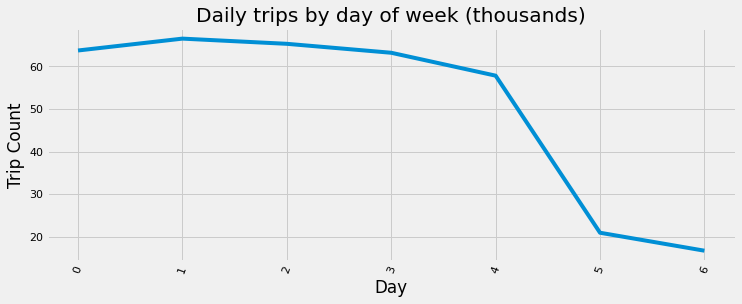

In [18]:
labelx= "Day"
labely = "Trip Count"
title= "Daily trips by day of week (thousands)"
group_plot(trips,["day"], 'size', labelx, labely, title)

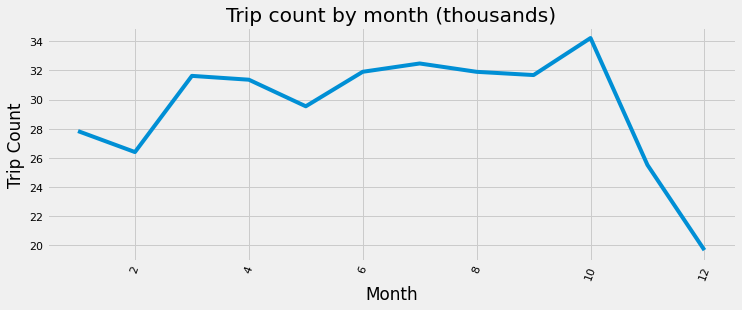

In [117]:
labelx= "Month"
labely = "Trip Count"
title= "Trip count by month (thousands)"
group_plot(trips,["month"], 'size', labelx, labely, title)

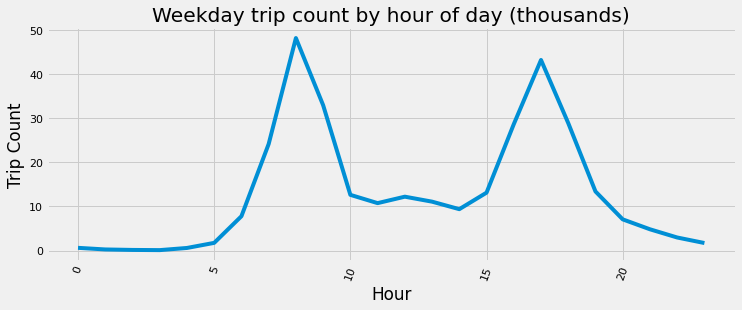

In [108]:
labelx= "Hour"
labely = "Trip Count"
title= "Weekday trip count by hour of day (thousands)"
group_plot(weekdays,["hour"], 'size', labelx, labely, title)

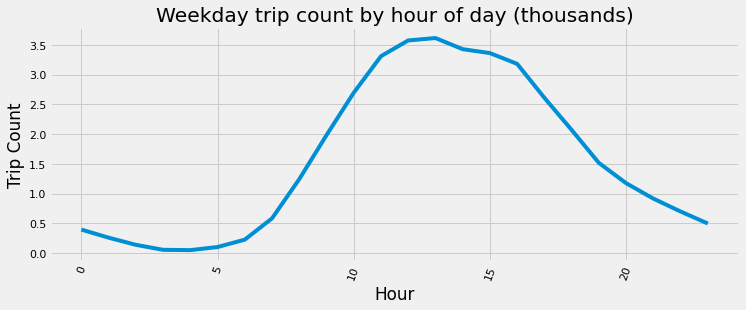

In [109]:
labelx= "Hour"
labely = "Trip Count"
title= "Weekday trip count by hour of day (thousands)"
group_plot(weekends,["hour"], 'size', labelx, labely, title)

In [19]:
trips.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,month,day,hour
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber,8,0,23
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber,8,0,23
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber,8,0,23
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber,8,0,23
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer,8,0,23


In [20]:
trips.to_csv('../data/trips_df.csv', index=False)

In [156]:
'''
Looks like this is getting the number of records per hour by
using the .size() function. But shouldn't we be looking for
the net, meaning we need to subtract bikes out ('Start Date')
from bikes in ('End Date')?

Also need to figure out how I'm capturing station info here.
'''
out_trips=trips.set_index("Start Date").resample("H").size().to_frame(name='out')

In [140]:
in_trips=trips.set_index("End Date").resample("H").size().to_frame(name='in')

In [139]:
out_trips.head()

,out
Start Date,
2014-09-01 00:00:00,3
2014-09-01 01:00:00,0
2014-09-01 02:00:00,0
2014-09-01 03:00:00,1
2014-09-01 04:00:00,2


In [141]:
in_trips.head()

,in
End Date,
2014-09-01 00:00:00,3
2014-09-01 01:00:00,0
2014-09-01 02:00:00,0
2014-09-01 03:00:00,0
2014-09-01 04:00:00,1


In [148]:
hourly_trips = pd.concat([out_trips, in_trips], axis=1)

In [153]:
hourly_trips.describe()

,out,in,net_rate
count,8760.000000,8760.000000,8760.000000
mean,40.428311,40.428311,0.000000
std,50.499493,50.548833,8.066653
min,0.000000,0.000000,-42.000000
25%,4.000000,4.000000,-2.000000
50%,23.000000,23.000000,0.000000
75%,50.000000,50.000000,3.000000
max,249.000000,235.000000,51.000000


In [150]:
hourly_trips['net_rate'] = hourly_trips['in'] - hourly_trips['out']

In [123]:
hourly_trips=hourly_total.to_frame(name="Total")

In [146]:
hourly_trips.index.rename('Date', inplace=True)

In [132]:
hourly_trips['Total']

Date
2014-09-01 00:00:00     3
2014-09-01 01:00:00     0
2014-09-01 02:00:00     0
2014-09-01 03:00:00     1
2014-09-01 04:00:00     2
                       ..
2015-08-31 19:00:00    72
2015-08-31 20:00:00    35
2015-08-31 21:00:00    13
2015-08-31 22:00:00     2
2015-08-31 23:00:00     7
Freq: H, Name: Total, Length: 8760, dtype: int64

#### Seems like trips is key to getting net rate per hour if datetime can be restricted to hour

In [43]:
trips['Start Date'] = trips['Start Date'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M'))

In [44]:
trips['End Date'] = trips['End Date'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M'))

In [45]:
trips['Start Date hr'] = trips['Start Date'].apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour))

In [46]:
trips['End Date hr'] = trips['End Date'].apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour))

#### Now I need to calculate the net bikes in and out

In [47]:
bikes_out_df = trips.groupby(['Start Station', 'Start Date hr']).count()['Trip ID'].reset_index()

In [48]:
bikes_out_df.rename(columns={"Start Station": "station", "Start Date hr": "Date hr", 'Trip ID': 'count'}, inplace=True)

In [49]:
bikes_in_df = trips.groupby(['End Station', 'End Date hr']).count()['Trip ID'].reset_index()

In [50]:
bikes_in_df.rename(columns={"End Station": "station", "End Date hr": "Date hr", 'Trip ID': 'count'}, inplace=True)

#### Combining the bikes-in and bikes-out data frames to get the net count per hour

In [51]:
net_bikes = bikes_in_df.merge(bikes_out_df, how='outer', on=['station', 'Date hr'],
                  suffixes=('_bikes_in', '_bikes_out'))

In [157]:
net_bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198122 entries, 0 to 198121
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   station          198122 non-null  int64         
 1   Date hr          198122 non-null  datetime64[ns]
 2   count_bikes_in   198122 non-null  float64       
 3   count_bikes_out  198122 non-null  float64       
 4   net rate         198122 non-null  float64       
 5   month            198122 non-null  int64         
 6   day              198122 non-null  int64         
 7   hour             198122 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 17.6 MB


In [53]:
net_bikes.fillna(0, inplace= True)

In [54]:
net_bikes['net rate'] = net_bikes['count_bikes_in'] - net_bikes['count_bikes_out']

In [60]:
net_bikes

,station,Date hr,count_bikes_in,count_bikes_out,net rate,month,day,hour
0,2,2014-09-01 14:00:00,1.0,0.0,1.0,9,0,14
1,2,2014-09-02 06:00:00,3.0,0.0,3.0,9,1,6
2,2,2014-09-02 07:00:00,6.0,3.0,3.0,9,1,7
3,2,2014-09-02 08:00:00,1.0,2.0,-1.0,9,1,8
4,2,2014-09-02 09:00:00,2.0,3.0,-1.0,9,1,9
...,...,...,...,...,...,...,...,...
198117,90,2015-08-30 13:00:00,0.0,1.0,-1.0,8,6,13
198118,90,2015-08-30 17:00:00,0.0,2.0,-2.0,8,6,17
198119,90,2015-08-30 19:00:00,0.0,2.0,-2.0,8,6,19
198120,90,2015-08-31 12:00:00,0.0,1.0,-1.0,8,0,12


In [59]:
net_bikes['month'] = net_bikes['Date hr'].dt.month
net_bikes['day'] = net_bikes['Date hr'].dt.dayofweek
net_bikes['hour'] = net_bikes['Date hr'].dt.hour

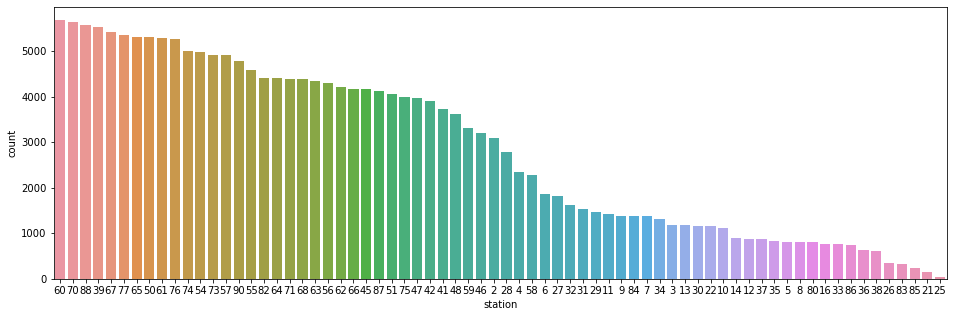

In [62]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(x=net_bikes['station'], order= net_bikes['station'].value_counts().index, ax=ax);

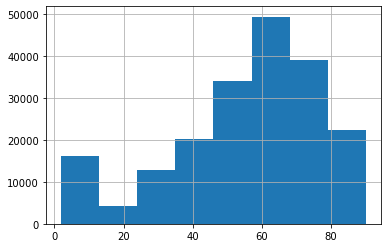

In [63]:
net_bikes['station'].hist(bins=int(np.sqrt(len(stations.Id))));

#### Using the net rate column as a target should serve for a simple linear regression model

In [20]:
net_bikes.to_csv('../data/net_bikes.csv', index=False)

### The model could be expanded by joining net_bikes to weather on date to account for conditions

In [21]:
weather.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [22]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1825 non-null   object 
 1   Max TemperatureF           1821 non-null   float64
 2   Mean TemperatureF          1821 non-null   float64
 3   Min TemperatureF           1821 non-null   float64
 4   Max Dew PointF             1775 non-null   float64
 5   MeanDew PointF             1775 non-null   float64
 6   Min DewpointF              1775 non-null   float64
 7   Max Humidity               1775 non-null   float64
 8   Mean Humidity              1775 non-null   float64
 9   Min Humidity               1775 non-null   float64
 10  Max Sea Level PressureIn   1824 non-null   float64
 11  Mean Sea Level PressureIn  1824 non-null   float64
 12  Min Sea Level PressureIn   1824 non-null   float64
 13  Max VisibilityMiles        1820 non-null   float